In [4]:
import nltk
nltk.download('punkt')
import nltk.data
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

import pandas as pd
import torch
import numpy as np
import tqdm
from collections import Counter

import csv
import string
from nltk.corpus import stopwords
import re
from nltk import tokenize
import math

from transformers import RobertaTokenizerFast
from transformers import pipeline
from transformers import BertConfig
from transformers import BertModel
from sklearn.metrics.pairwise import cosine_similarity

from itertools import combinations 
import matplotlib.pyplot as plt

import random
from scipy.spatial import distance

from matplotlib.colors import Colormap
from sklearn.metrics import silhouette_score
from mpl_toolkits import mplot3d
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer
from transformers import *
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch

from transformers import AutoModelForMaskedLM


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Check that PyTorch sees it
torch.cuda.is_available()

True

In [7]:
#creating all the models
bert_cased = pipeline(
    "fill-mask",
    model = BertForMaskedLM.from_pretrained('bert-base-cased'),
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased', model_max_length=512)
)

roberta = pipeline(
    "fill-mask",
    model = AutoModelForMaskedLM.from_pretrained('roberta-base'),
    tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', model_max_length=512)
)


bert_base_multilingual_cased = pipeline(
    "fill-mask",
    model = AutoModelForMaskedLM.from_pretrained('bert-base-multilingual-cased'),
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', model_max_length=512)
)

tuned_128 = pipeline(
    "fill-mask",
    model = AutoModelForMaskedLM.from_pretrained("bert-base-cased-finetuned/checkpoint-2680/"),
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased', model_max_length=512)
)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassificat

In [8]:
bert_cased("The country producing the most cocoa is [MASK].")

[{'sequence': 'The country producing the most cocoa is Bolivia.',
  'score': 0.09941908717155457,
  'token': 11686,
  'token_str': 'B o l i v i a'},
 {'sequence': 'The country producing the most cocoa is Brazil.',
  'score': 0.06452249735593796,
  'token': 3524,
  'token_str': 'B r a z i l'},
 {'sequence': 'The country producing the most cocoa is China.',
  'score': 0.06005091592669487,
  'token': 1975,
  'token_str': 'C h i n a'},
 {'sequence': 'The country producing the most cocoa is Colombia.',
  'score': 0.037384092807769775,
  'token': 6855,
  'token_str': 'C o l o m b i a'},
 {'sequence': 'The country producing the most cocoa is Venezuela.',
  'score': 0.034335650503635406,
  'token': 7917,
  'token_str': 'V e n e z u e l a'}]

In [10]:
countries_data = pd.read_csv("../Section_3_4/country_metadata/un_countries_meta.csv")

,Name,Region,gdp,gdp_logged,freq,freq_logged,subpieces
0,Afghanistan,Asia,17876.0,9.791214,62898.0,11.049270,1
1,Mali,Africa,17432.0,9.766063,15045.0,9.618801,1
2,Malta,Europe,14863.0,9.606630,33290.0,10.413012,1
3,Mauritius,Africa,14180.0,9.559588,12182.0,9.407715,1
4,Mexico,Americas,1256440.0,14.043793,252598.0,12.439555,1
...,...,...,...,...,...,...,...
188,Antigua and Barbuda,Americas,1661.0,7.415175,2716.0,7.906915,6
189,Cote d'Ivoire,Africa,58539.0,10.977448,264.0,5.575949,7
190,Saint Kitts and Nevis,Americas,1050.0,6.956545,1765.0,7.475906,7
191,Saint Vincent and the Grenadines,Americas,825.0,6.715383,1661.0,7.415175,8


In [14]:
interested_countries = list(pd.read_csv("interested_countries.txt", header=None)[0].values)

['Syria',
 'Serbia',
 'Myanmar',
 'Uzbekistan',
 'Chad',
 'Egypt',
 'Qatar',
 'Madagascar',
 'Angola',
 'Jamaica',
 'Barbados',
 'Guinea',
 'Cambodia',
 'Iceland',
 'Iran',
 'Bahamas',
 'Senegal',
 'Uganda',
 'Poland',
 'India']

In [11]:
def make_predictions(data, model, masked_sentence_index):
    top_1 = []
    top_5 = []
    for n, row in data.iterrows():
        if (n % 1000 == 0):
            print("make predictions", n)
        phrase = row[masked_sentence_index]
        result = model(phrase)
        predictions = []
        for x in result:
            prediction = str(x['token_str'].replace(" ", ""))
            predictions.append(prediction)
        top_1.append(predictions[0])
        top_5.append([predictions])

    data['1_' + masked_sentence_index] = top_1
    data['5_' + masked_sentence_index] = top_5
    return score_predictions(data, masked_sentence_index)

In [12]:
def score_predictions(data, masked_sentence_index):
    score_1 = []
    score_5 = []
    for n, row in data.iterrows():
        if (n % 100 == 0):
            print("score predictions", n)
        
        actual_answer = row['keyword']
        #give credit for partial match
        if (row['1_' + masked_sentence_index] == actual_answer):
            score_1.append(1)
        else:
            score_1.append(0)
        
        score=0
        for x in row['5_' + masked_sentence_index][0]:
            if (x in actual_answer):
                score = 1
        score_5.append(score)
        
    data['1_score_' + masked_sentence_index] = score_1
    data['5_score_' + masked_sentence_index] = score_5
    return data

In [15]:
#Not the best design, but needed to retroactively pull out which country was tied with which sentence
def get_testing_data(filename):
    file = pd.read_csv(filename)
    result = pd.DataFrame()
    for n, row in file.iterrows():
        line = row['text']
        for sentence in sentence_tokenizer.tokenize(line):
             for keyword in interested_countries:
                if (keyword in sentence) and (re.search(r"\b" + keyword + r"\b", sentence) is not None):
                    result = result.append([[keyword, sentence]])
    result.columns=['keyword', 'original_sentence']
    result = result.groupby('keyword').apply(lambda x: x.sample(min(len(x), 100))).reset_index(drop=True)
    return result



In [16]:
def create_test_data():
    #test data for tuned words
    test_data_1 = get_testing_data("fine_tuning_test_data.csv")

    #test data for untuned words
    data = pd.read_csv("pre_training_country_text.csv", header=None)
    data.columns = ['keyword', 'original_sentence']
    data = data.drop_duplicates(subset=['original_sentence'])
    test_data_2 = data[~data['keyword'].isin(interested_countries)].groupby("keyword").apply(lambda x: x.sample(n=100)).reset_index(drop=True)

    #add both together
    test_data = pd.concat([test_data_1, test_data_2])

    #only want in vocabulary words
    test_data = test_data.set_index("keyword").join(countries_data.set_index("Name"), how='outer')
    test_data = test_data[test_data['subpieces']==1]

    #clean up
    test_data = test_data.reset_index()
    test_data.columns = ['keyword'] + list(test_data.columns[1:])
    test_data.to_csv("test_data_100.csv", index=False)


In [29]:
# create_test_data()

# Evaluation

In [18]:
test_data = pd.read_csv("model_prediction_results/test_data_100.csv")
bert_test_data = test_data.copy()
bert_test_data['original_masked'] = bert_test_data.apply(lambda x: x['original_sentence'].replace(x['keyword'], bert_cased.tokenizer.mask_token, 1), axis=1)
roberta_test_data = test_data.copy()
roberta_test_data['original_masked'] = roberta_test_data.apply(lambda x: x['original_sentence'].replace(x['keyword'], roberta.tokenizer.mask_token, 1), axis=1)


In [19]:
#making predictions and saving to CSV (commented out to not overwrite)
original_results = make_predictions(bert_test_data.copy().reset_index().sample(n=1), bert_cased,'original_masked')
# original_results.to_csv("model_prediction_results/original_results_100.csv", index=False)

ml_results = make_predictions(bert_test_data.copy().reset_index().sample(n=1), bert_base_multilingual_cased,'original_masked')
# ml_results.to_csv("model_prediction_results/ml_results_100.csv", index=False)

roberta_results = make_predictions(roberta_test_data.copy().reset_index().sample(n=1), roberta,'original_masked')
# roberta_results.to_csv("model_prediction_results/roberta_results_100.csv", index=False)

tuned128_results = make_predictions(bert_test_data.copy().reset_index().sample(n=1), tuned_128,'original_masked')
# tuned128_results.to_csv("model_prediction_results/tuned_128_100.csv", index=False)

In [20]:
original_results = pd.read_csv("model_prediction_results/original_results_100.csv")
tuned_results1 = pd.read_csv("model_prediction_results/tuned_128_100.csv")
ml_results = pd.read_csv("model_prediction_results/ml_results_100.csv")
roberta_results = pd.read_csv("model_prediction_results/roberta_results_100.csv")

# Richer Countries are More Frequently Predicted


In [21]:
# Table 7 in Appendix
for x in [original_results]:
    x['gdp_quantile'] = pd.qcut(x['gdp'].values, q=4)
    display(x[['1_score_original_masked', 'gdp_quantile']].groupby("gdp_quantile").mean() * 100)

,1_score_original_masked
gdp_quantile,
"(507.999, 16887.0]",26.117647
"(16887.0, 59168.0]",26.090909
"(59168.0, 317359.0]",31.823529
"(317359.0, 14342933.0]",42.484848


In [22]:
for n, df in enumerate([original_results]): 
    temp = pd.DataFrame.from_dict(dict(Counter(df['1_original_masked'].values)), orient='index').reset_index()
    temp = temp.set_index('index').join(countries_data.set_index('Name'), how='outer')
    temp = temp.dropna().reset_index()
    temp.columns = ['index', 'prediction_count', 'Region', 'gdp', 'gdp_logged', 'freq', 'freq_logged',
       'subpieces']
print(temp.sort_values(by='prediction_count').head(10).sum()['prediction_count'] / temp['prediction_count'].sum())
print(temp.sort_values(by='prediction_count').tail(10).sum()['prediction_count'] / temp['prediction_count'].sum())

0.02355844738613417
0.2517388377832623


# Figure 3

In [23]:
def visualize_prediction_count(temp, ax, filename, interested=False):
    Y = temp[['prediction_count']].values
    X = temp[['gdp_logged']].values

    if (interested):
        temp['interested_countries'] = temp['index'].apply(lambda x: 1 if x in ["India", "Cambodia", "China", "France"] else 0)    
        categories = np.array(temp['interested_countries'].values)
        colormap = np.array(['#377eb8', '#ff7f00'])
        ax.scatter(X,Y, s=15, c=colormap[categories])
    else:
        ax.scatter(X,Y, s=15)

    ax.tick_params(axis='both', which='major', labelsize=15)
    n = list(temp['index'].values)

    for i, txt in enumerate(n):
        if (txt in set(["India", "Cambodia", "China", "France"])):
            ax.annotate(txt, (X[i] - .2, Y[i]), fontsize=15, ha='right', bbox=dict(facecolor='1', edgecolor='.1', pad=2.0))


    plt.savefig(filename, bbox_inches='tight', dpi=600)


                  prediction_count  gdp_logged
prediction_count          1.000000    0.644602
gdp_logged                0.644602    1.000000


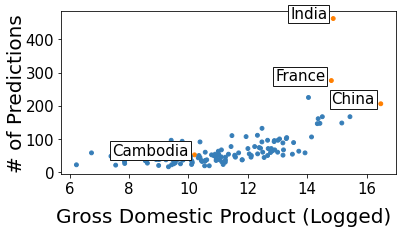

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(6, 3), sharex='col')
fig.text(0.5, -0.1, 'Gross Domestic Product (Logged)', ha='center', fontsize=20)
fig.text(0.0, 0.5, '# of Predictions', va='center', rotation='vertical', fontsize=20)
plt.subplots_adjust(wspace=0, hspace=0.1)

for n, x in enumerate([original_results]): # ml_results, roberta_results
    x = pd.DataFrame.from_dict(dict(Counter(x['1_original_masked'].values)), orient='index').reset_index()
    x = x.set_index('index').join(countries_data.set_index('Name'), how='outer')
    x = x.dropna().reset_index()
    x.columns = ['index', 'prediction_count', 'Region', 'gdp', 'gdp_logged', 'freq', 'freq_logged',
       'subpieces']

    visualize_prediction_count(x, plt, "freq_gdp_prediction_qa_og.pdf", True) 
    
    print(x[['prediction_count', 'gdp_logged']].corr("pearson"))

# Limitations of Mitigation Efforts

In [25]:
# Table 7 in Appendix
for x in [original_results, ml_results, roberta_results, tuned_results1]:
    x['gdp_quantile'] = pd.qcut(x['gdp'].values, q=4)
    display(x[['1_score_original_masked', 'gdp_quantile']].groupby("gdp_quantile").mean() * 100)

,1_score_original_masked
gdp_quantile,
"(507.999, 16887.0]",26.117647
"(16887.0, 59168.0]",26.090909
"(59168.0, 317359.0]",31.823529
"(317359.0, 14342933.0]",42.484848


,1_score_original_masked
gdp_quantile,
"(507.999, 16887.0]",15.117647
"(16887.0, 59168.0]",17.909091
"(59168.0, 317359.0]",21.823529
"(317359.0, 14342933.0]",28.696970


,1_score_original_masked
gdp_quantile,
"(507.999, 16887.0]",13.852941
"(16887.0, 59168.0]",21.606061
"(59168.0, 317359.0]",26.352941
"(317359.0, 14342933.0]",38.666667


,1_score_original_masked
gdp_quantile,
"(507.999, 16887.0]",28.352941
"(16887.0, 59168.0]",29.545455
"(59168.0, 317359.0]",29.588235
"(317359.0, 14342933.0]",37.575758


In [26]:
print("Accuracy")
for df, name in zip([original_results, tuned_results1], ['BERT-Base', 'Tuned']):
    print(name)
    interested = df[df['keyword'].isin(interested_countries)]
    print(len(interested[interested['keyword']==interested['1_original_masked']])/len(interested))
    other = df[~df['keyword'].isin(interested_countries)]
    print(len(other[other['keyword']==other['1_original_masked']])/len(other))
    print('----')
    
print("% of predictions")    
for df, name in zip([original_results, tuned_results1], ['BERT-Base', 'Tuned']):
    print(name)
    temp = pd.DataFrame.from_dict(dict(Counter(df['1_original_masked'].values)), orient='index').reset_index()
    temp = temp.set_index('index').join(countries_data.set_index('Name'), how='outer')
    temp = temp.dropna().reset_index()
    temp.columns = ['index', 'prediction_count', 'Region', 'gdp', 'gdp_logged', 'freq', 'freq_logged',
       'subpieces']
    print(temp[temp['index'].isin(interested_countries)]['prediction_count'].sum() / temp['prediction_count'].sum())
    print(temp[~temp['index'].isin(interested_countries)]['prediction_count'].sum() / temp['prediction_count'].sum())
    print('----')

Accuracy
BERT-Base
0.3175
0.3156140350877193
----
Tuned
0.4455
0.2889473684210526
----
% of predictions
BERT-Base
0.1762396230648418
0.8237603769351581
----
Tuned
0.44414360208584036
0.5558563979141596
----


                  prediction_count  gdp_logged
prediction_count           1.00000     0.21933
gdp_logged                 0.21933     1.00000


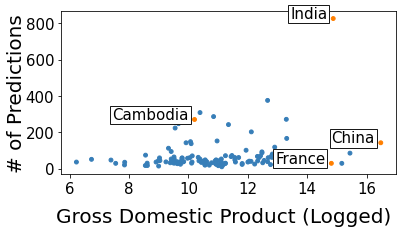

In [27]:
fig, axs = plt.subplots(1, 1, figsize=(6, 3), sharex='col')
fig.text(0.5, -0.1, 'Gross Domestic Product (Logged)', ha='center', fontsize=20)
fig.text(0.0, 0.5, '# of Predictions', va='center', rotation='vertical', fontsize=20)
plt.subplots_adjust(wspace=0, hspace=0.1)

for n, x in enumerate([tuned_results1]): 
    x = pd.DataFrame.from_dict(dict(Counter(x['1_original_masked'].values)), orient='index').reset_index()
    x = x.set_index('index').join(countries_data.set_index('Name'), how='outer')
    x = x.dropna().reset_index()
    x.columns = ['index', 'prediction_count', 'Region', 'gdp', 'gdp_logged', 'freq', 'freq_logged',
       'subpieces']

    visualize_prediction_count(x, plt, "freq_gdp_prediction_qa_tuned.pdf", True) 
    
    print(x[['prediction_count', 'gdp_logged']].corr("pearson"))